# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.63KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

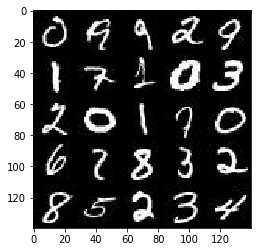

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

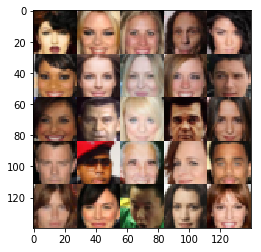

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    

    return real_input, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)


        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [45]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        alpha = 0.2

        x1 = tf.layers.dense(z, 7*7*512)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
    
#         x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
#         x4 = tf.layers.batch_normalization(x4, training=is_train)
#         x4 = tf.maximum(alpha * x4, x4)
        #print(x4.shape)
        
#         x5 = tf.layers.conv2d_transpose(x4, 64, 5, strides=2, padding='valid')
#         x5 = tf.layers.batch_normalization(x5, training=is_train)
#         x5 = tf.maximum(alpha * x5, x5)
#         print(x5.shape)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        #print(logits.shape)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [36]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    alpha = 0.02
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [49]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
# TODO: Build Model
    #saver = tf.train.Saver()
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    #tf.reset_default_graph()
    
    #print(data_shape)
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)

#         saver.save(sess, './checkpoints/generator.ckpt')

#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
    
    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
    
    return losses, samples
                
         

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4113... Generator Loss: 1.6502
Epoch 1/2... Discriminator Loss: 0.1387... Generator Loss: 2.9203
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 1.5310... Generator Loss: 0.4535
Epoch 1/2... Discriminator Loss: 1.7051... Generator Loss: 1.9168
Epoch 1/2... Discriminator Loss: 2.4750... Generator Loss: 0.1583
Epoch 1/2... Discriminator Loss: 2.6234... Generator Loss: 0.6297
Epoch 1/2... Discriminator Loss: 2.1017... Generator Loss: 0.3513
Epoch 1/2... Discriminator Loss: 2.0425... Generator Loss: 0.3944
Epoch 1/2... Discriminator Loss: 1.9585... Generator Loss: 0.3134
Epoch 1/2... Discriminator Loss: 2.1822... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 2.0830... Generator Loss: 0.2144
Epoch 1/2... Discriminator Loss: 1.8867... Generator Loss: 0.4845
Epoch 1/2... Discriminator Loss: 1.8598... Generator Loss: 0.3315
Epoch 1/2... Discriminator Loss: 1.9298... Generator Loss: 0.8851
Epoch 1/2.

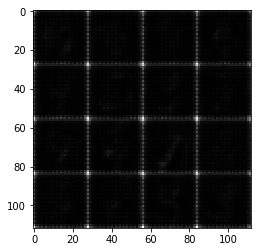

Epoch 1/2... Discriminator Loss: 1.5801... Generator Loss: 0.8388
Epoch 1/2... Discriminator Loss: 1.6181... Generator Loss: 0.3519
Epoch 1/2... Discriminator Loss: 1.5153... Generator Loss: 0.7599
Epoch 1/2... Discriminator Loss: 1.5031... Generator Loss: 0.4230
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 1.1466
Epoch 1/2... Discriminator Loss: 1.4644... Generator Loss: 0.4335
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.5454
Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 0.4230
Epoch 1/2... Discriminator Loss: 1.5909... Generator Loss: 1.2221
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.4527
Epoch 1/2... Discriminator Loss: 1.5597... Generator Loss: 1.1866
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.6165
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 1.4112
Epoch 1/2... Discriminator Loss: 1.4835... Generator Loss: 0.3618
Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 1.0361
Epoch 1/2.

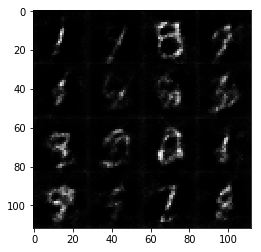

Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 0.9388
Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.4237
Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 0.8531
Epoch 1/2... Discriminator Loss: 1.6956... Generator Loss: 0.2842
Epoch 1/2... Discriminator Loss: 1.4923... Generator Loss: 0.6706
Epoch 1/2... Discriminator Loss: 1.4671... Generator Loss: 0.6451
Epoch 1/2... Discriminator Loss: 1.5360... Generator Loss: 0.3969
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 1.9005
Epoch 1/2... Discriminator Loss: 1.4457... Generator Loss: 0.6611
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 0.4286
Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 1.4980... Generator Loss: 0.4714
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.7212
Epoch 1/2... Discriminator Loss: 1.7865... Generator Loss: 0.2461
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.7681
Epoch 1/2.

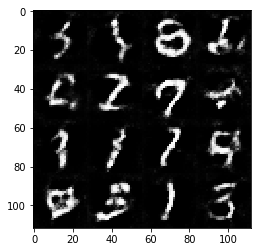

Epoch 1/2... Discriminator Loss: 1.4420... Generator Loss: 0.4808
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.9277
Epoch 1/2... Discriminator Loss: 1.5176... Generator Loss: 0.3967
Epoch 1/2... Discriminator Loss: 1.4494... Generator Loss: 0.8805
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.5593
Epoch 1/2... Discriminator Loss: 1.4450... Generator Loss: 0.4754
Epoch 1/2... Discriminator Loss: 1.5843... Generator Loss: 0.8851
Epoch 1/2... Discriminator Loss: 1.5170... Generator Loss: 0.4200
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.7276
Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 0.4707
Epoch 1/2... Discriminator Loss: 1.5266... Generator Loss: 1.2124
Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 0.5387
Epoch 1/2... Discriminator Loss: 1.5428... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.4905
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.6228
Epoch 1/2.

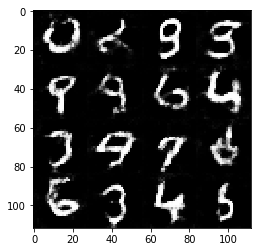

Epoch 1/2... Discriminator Loss: 1.4880... Generator Loss: 0.4539
Epoch 1/2... Discriminator Loss: 1.4982... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.7074
Epoch 1/2... Discriminator Loss: 1.7088... Generator Loss: 0.2928
Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 0.8357
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.5993
Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 0.5146
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.7047
Epoch 1/2... Discriminator Loss: 1.6357... Generator Loss: 0.3169
Epoch 1/2... Discriminator Loss: 1.4382... Generator Loss: 0.6843
Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 0.6400
Epoch 1/2... Discriminator Loss: 1.6567... Generator Loss: 0.3104
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 1.6192... Generator Loss: 0.3375
Epoch 2/2.

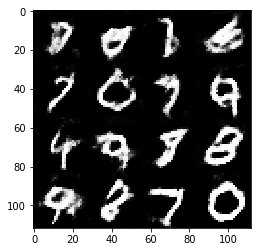

Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.5757
Epoch 2/2... Discriminator Loss: 1.4128... Generator Loss: 0.4942
Epoch 2/2... Discriminator Loss: 1.4963... Generator Loss: 0.9659
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.6593
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.4675
Epoch 2/2... Discriminator Loss: 1.4308... Generator Loss: 0.8210
Epoch 2/2... Discriminator Loss: 1.5861... Generator Loss: 0.3152
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.8759
Epoch 2/2... Discriminator Loss: 1.4636... Generator Loss: 0.6447
Epoch 2/2... Discriminator Loss: 1.5260... Generator Loss: 0.3882
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.7748
Epoch 2/2... Discriminator Loss: 1.4113... Generator Loss: 0.7952
Epoch 2/2... Discriminator Loss: 1.5248... Generator Loss: 0.3812
Epoch 2/2... Discriminator Loss: 1.4095... Generator Loss: 0.7811
Epoch 2/2... Discriminator Loss: 1.5317... Generator Loss: 0.3640
Epoch 2/2.

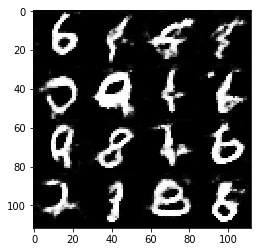

Epoch 2/2... Discriminator Loss: 1.5719... Generator Loss: 0.3625
Epoch 2/2... Discriminator Loss: 1.4683... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 1.4443... Generator Loss: 0.4267
Epoch 2/2... Discriminator Loss: 1.4405... Generator Loss: 0.6297
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.6801
Epoch 2/2... Discriminator Loss: 1.6014... Generator Loss: 0.3391
Epoch 2/2... Discriminator Loss: 1.3806... Generator Loss: 0.7101
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.5230
Epoch 2/2... Discriminator Loss: 1.3514... Generator Loss: 0.6887
Epoch 2/2... Discriminator Loss: 1.4200... Generator Loss: 0.5448
Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 0.5688
Epoch 2/2... Discriminator Loss: 1.5639... Generator Loss: 1.1423
Epoch 2/2... Discriminator Loss: 1.5844... Generator Loss: 0.3558
Epoch 2/2... Discriminator Loss: 1.4747... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.3803... Generator Loss: 0.6426
Epoch 2/2.

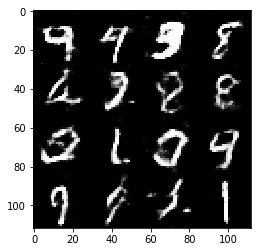

Epoch 2/2... Discriminator Loss: 1.6196... Generator Loss: 0.3172
Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 0.8142
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.5839
Epoch 2/2... Discriminator Loss: 1.4409... Generator Loss: 0.7822
Epoch 2/2... Discriminator Loss: 1.5628... Generator Loss: 0.3767
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 0.5614
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.5673
Epoch 2/2... Discriminator Loss: 1.7005... Generator Loss: 0.2822
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.7442
Epoch 2/2... Discriminator Loss: 1.4620... Generator Loss: 0.4090
Epoch 2/2... Discriminator Loss: 1.4721... Generator Loss: 0.7504
Epoch 2/2... Discriminator Loss: 1.5304... Generator Loss: 0.3652
Epoch 2/2... Discriminator Loss: 1.4743... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 1.4636... Generator Loss: 0.3882
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.6303
Epoch 2/2.

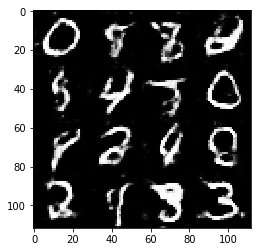

Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.6290... Generator Loss: 0.3141
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.6447
Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.5240
Epoch 2/2... Discriminator Loss: 1.8423... Generator Loss: 1.5110
Epoch 2/2... Discriminator Loss: 1.4591... Generator Loss: 0.5430
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.5757
Epoch 2/2... Discriminator Loss: 1.4425... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 0.7667
Epoch 2/2... Discriminator Loss: 1.6284... Generator Loss: 0.3235
Epoch 2/2... Discriminator Loss: 1.3542... Generator Loss: 0.5891
Epoch 2/2... Discriminator Loss: 1.7081... Generator Loss: 0.2854
Epoch 2/2... Discriminator Loss: 1.6530... Generator Loss: 1.2114
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.6254
Epoch 2/2.

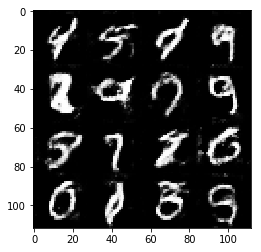

Epoch 2/2... Discriminator Loss: 1.9501... Generator Loss: 0.2075
Epoch 2/2... Discriminator Loss: 1.4318... Generator Loss: 0.5191
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.5349
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.6905
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.4454
Epoch 2/2... Discriminator Loss: 1.9411... Generator Loss: 1.3900
Epoch 2/2... Discriminator Loss: 1.3031... Generator Loss: 0.8811


RuntimeError: Attempted to use a closed Session.

In [50]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4

print_every = 5
show_every = 100



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.8165... Generator Loss: 0.0663
Epoch 1/1... Discriminator Loss: 3.8623... Generator Loss: 0.0629
Epoch 1/1... Discriminator Loss: 3.3398... Generator Loss: 0.1600
Epoch 1/1... Discriminator Loss: 2.5948... Generator Loss: 0.3164


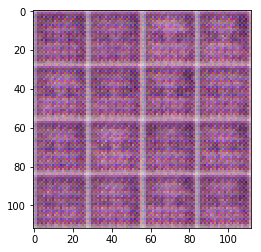

Epoch 1/1... Discriminator Loss: 2.2881... Generator Loss: 0.3201
Epoch 1/1... Discriminator Loss: 1.8003... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 2.2588... Generator Loss: 0.1659
Epoch 1/1... Discriminator Loss: 1.9310... Generator Loss: 0.3281


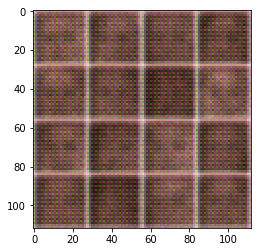

Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.4377
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.6426
Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.0449


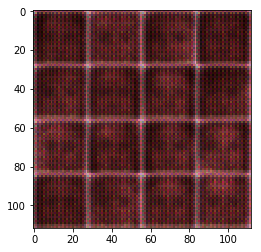

Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 1.7044
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 1.3441


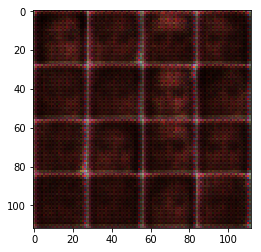

Epoch 1/1... Discriminator Loss: 2.1389... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 2.3370... Generator Loss: 0.3338
Epoch 1/1... Discriminator Loss: 2.3304... Generator Loss: 0.3332
Epoch 1/1... Discriminator Loss: 2.0778... Generator Loss: 0.4446


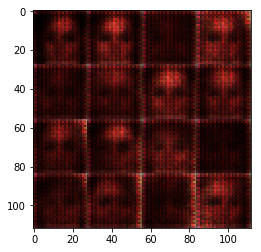

Epoch 1/1... Discriminator Loss: 2.1870... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.8639... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.8897... Generator Loss: 0.4315
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.7849


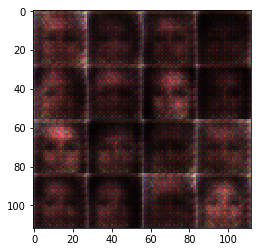

Epoch 1/1... Discriminator Loss: 1.7690... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.9140... Generator Loss: 0.4261
Epoch 1/1... Discriminator Loss: 1.6648... Generator Loss: 0.4157
Epoch 1/1... Discriminator Loss: 1.6338... Generator Loss: 0.5634


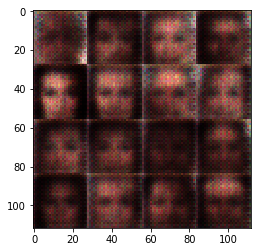

Epoch 1/1... Discriminator Loss: 1.7518... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.8419... Generator Loss: 0.3848
Epoch 1/1... Discriminator Loss: 1.6979... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.5155


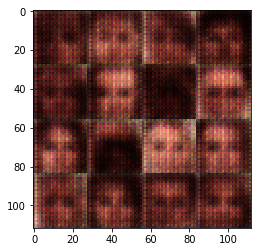

Epoch 1/1... Discriminator Loss: 1.6967... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.7318... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 1.8397... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.6024


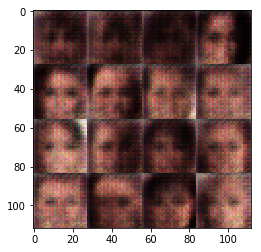

Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.5882... Generator Loss: 0.6573


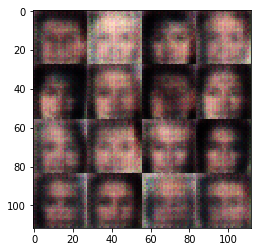

Epoch 1/1... Discriminator Loss: 1.5873... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.6838


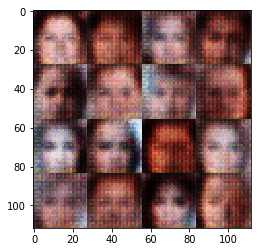

Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.4089


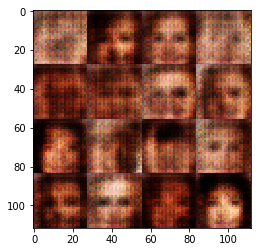

Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 1.6803... Generator Loss: 0.3261
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.4198
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.4927


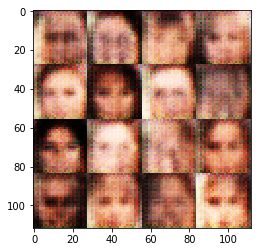

Epoch 1/1... Discriminator Loss: 2.2922... Generator Loss: 0.1586
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.4140
Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.7265


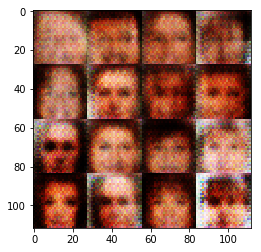

Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.7651... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.7666... Generator Loss: 0.4426
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.9665


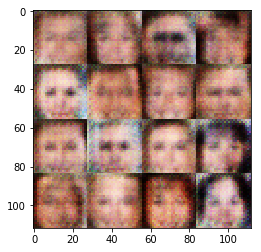

Epoch 1/1... Discriminator Loss: 1.6178... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.7190... Generator Loss: 0.3831
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.6198


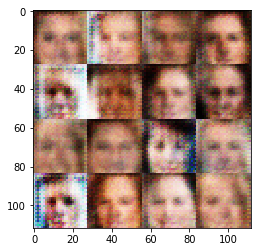

Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.8557... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.6742... Generator Loss: 0.5917


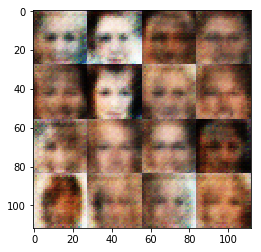

Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.6688... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.7533... Generator Loss: 0.5316


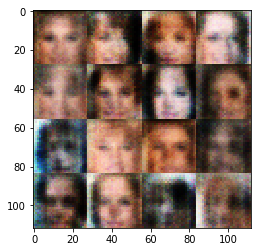

Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.6535... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.6432


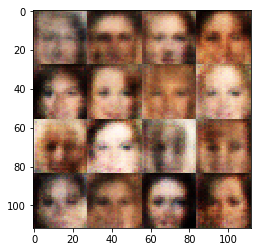

Epoch 1/1... Discriminator Loss: 1.6517... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6510


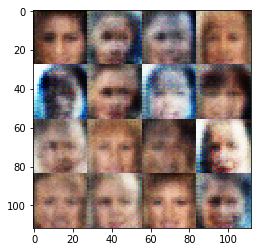

Epoch 1/1... Discriminator Loss: 1.6202... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.6272... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6357


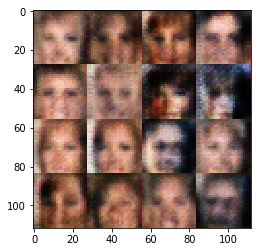

Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.6132


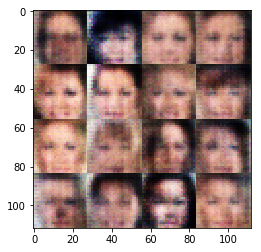

Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.6552


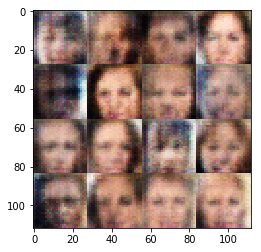

Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6297


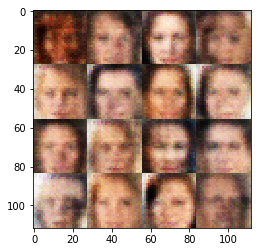

Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.6213


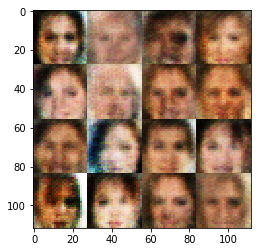

Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6652


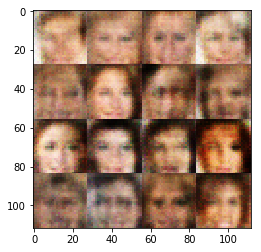

Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.6614


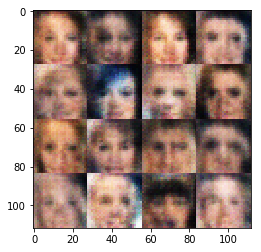

Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.6163


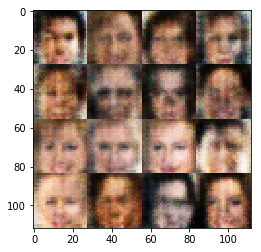

Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.6367


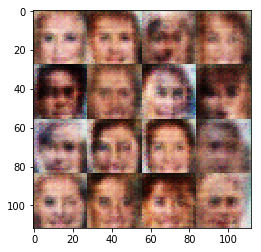

Epoch 1/1... Discriminator Loss: 1.5736... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6686


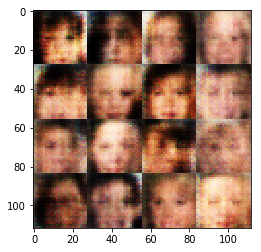

Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.5776


KeyboardInterrupt: 

In [51]:
batch_size = 128
z_dim = 112
learning_rate = 0.0002
beta1 = 0.5

print_every = 5
show_every = 20


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.